# Parameterizing Vertical Mixing Coefficients in the Ocean Surface Boundary Layer Using Neural Networks


In this notebook, we reproduce a portion of the analysis carried out by\
**Sane et al. (2023) "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks." Journal of Advances in Modeling Earth Systems 15.10: [e2023MS003890](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023MS003890)** (with original code and data at https://zenodo.org/records/8293998)

### Tasks Covered Here
- **Data Processing and Preparation**: Reading and filtering output from the Generalized Ocean Turbulence Model (GOTM) (GOTM is section 3.3 of Sane et al. 2023).
- **Neural Network Training**: Implementing neural networks to predict shape function $ g(\sigma) $ based on input physical parameters ($ \mathcal{N}_1 $.).
- **Hyperparameter Optimization**: Conducting a hyperparameter sweep to evaluate the effect of different model architectures (e.g., number of layers, nodes) on performance.
- **Model Evaluation and Visualization**: Analyzing the ML model skill using training/validation loss
- **Visualizing results**: Reproducing Figures 1-4 of Sane et al. 2023.
  
### Estimated Compute Time
- On LEAP Pangeo GPU configuration in February 2025, this notebook should run to completion in ~10 minutes
- This notebook will take several hours on LEAP-Pangeo education CPU configuration (4 CPU, 32GB RAM). 
- Options for speed up include lowering patience to triggering faster early stopping or further limiting hyperparameter sweep. 

### Collaboration Guidelines for Climate Prediction Challenges with Machine Learning (Spring 2025), Columbia University Earth and Environmental Sciences and Statistics
- GitHub sharing is recommended. 
  - We have prepared a [Github Tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md) to help. 
  - If this is not working for you, please reach out with questions.

# 1. Setup workspace and Import packages

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/Teaching/CPCsp2025/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization


# 2. Introduction


Vertical mixing in the ocean surface boundary layer (OSBL) plays a vital role in regulating the exchange of heat, momentum, and carbon between the atmosphere and the ocean interior. As a key determinant in the rate of ocean heat uptake, the OBSL plays a central role in the ocean's modulation of global air temperatures and in the sea level rise that results from a warming ocean. The OBSL also modulates the rate the ocean absorbs anthropogenic CO$_2$, thus playing a key role in the ocean's modulation atmospheric CO$_2$ levels, and thus, on climate change. If these processes are to be confidently projected for the future, it is critical that the OBSL be accurately represented in ocean models and the ocean components of Earth System Models.  

In sum, accurate parameterization of upper ocean vertical mixing is a critical component of ocean and climate modeling.  

Upper ocean vertical mixing typically represented as a vertically-varying diffusivity parameter $ \kappa_\phi (\sigma) $, where $\kappa$ is a variable diffisivity of scalar $\phi$, and $\sigma$ is a vertical index scaled to the depth of the upper ocean mixed layer.

Traditionally, vertical diffusivity is parameterized using **universal shape functions**, such as the dashed line shown in the first figure below. These fixed, predefined profiles assume uniformity across diverse ocean conditions. However, as illustrated in Figure 1, shape functions derived from more sophisticated, but more computationally expensive, second moment closure (SMC) methods (blue shaded region) demonstrate significant variability under different forcing conditions. The discrepancy between the universal shape function and SMC-derived profiles highlights a fundamental limitation: universal functions fail to capture the dynamic, environment-dependent behavior of vertical mixing in the OBSL.

This deficiency motivates the need for a more adaptive and accurate approach. Sane et al. (2023) propose a **neural network-based model** to replace the universal shape function. Neural networks offer the flexibility to learn complex, nonlinear relationships from data and can dynamically adjust the shape function to reflect varying physical conditions. This data-driven, physics-aware method bridges the gap between traditional parameterization schemes and the variability observed in high-fidelity SMC models. Though not the focus here, the approach of Sane et al. (2023) is also designed for seamless integration and computational efficiency in existing global ocean model codes; the impacts of this implementation is illustrated in section 4 of the paper. 

The approach integrates two neural networks:

1. $ \mathcal{N}_1 $: Predicts the shape function $ g(\sigma) $, capturing the vertical structure of diffusivity.
2. $ \mathcal{N}_2 $: Predicts the velocity scale $ v_0 $, which, combined with $ g(\sigma) $, yields the full diffusivity profile.

By leveraging neural networks, the authors aim to enhance the accuracy and generalizability of vertical mixing parameterizations in OGCMs, enabling more reliable ocean and climate predictions.

Here, we will focus on predicting the shape function $ g(\sigma) $ for vertical diffusivity using the neural network  $ \mathcal{N}_1 $.

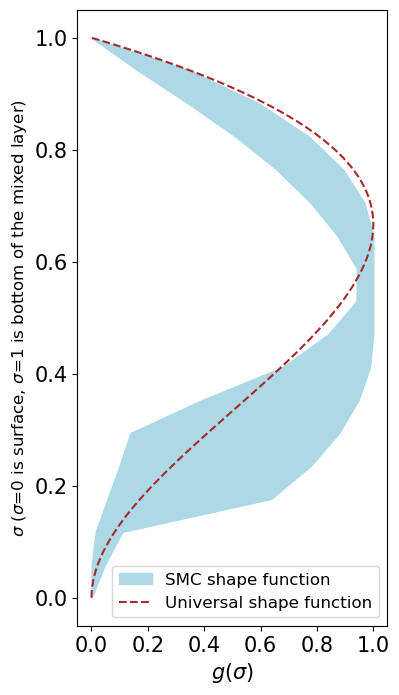

In [3]:
# Load GOTM training data produced by Sane et al. 2023
# Plot the assumed univeral shape function vs. GOTM results to illustrate the qualitative differences

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

h=d['h'][:]
h_ind1=np.where(h>10)[0]
h_ind2=np.where(h<700)[0]
h_ind=np.intersect1d(h_ind1,h_ind2)
sf1=d['SF'][h_ind,:]
sf1=sf1[237945:237945+5000,:] # randomly selected few profiles.

sf=np.zeros([len(sf1),16])

sf1 = sf1.values if hasattr(sf1, "values") else sf1
sf = sf1 / np.max(sf1, axis=1, keepdims=True)

# define vertical coordinate
sig=np.linspace(0,1,18)

# define universal shape function, section 2
# gamma = 2
z=np.linspace(0,1,100)
z1=z*(1-z)**2
z1=z1/np.max(z1)

sfmin=np.zeros(18)
sfmax=np.zeros(18)
sfmin[1:17]=np.min(sf,axis=0)
sfmax[1:17]=np.max(sf,axis=0)

plt.figure(figsize=(4,8))
#plt.plot(sfmin,sig,'o')
#plt.plot(sfmax,sig,'o')
plt.fill_betweenx(sig,sfmin,sfmax,color='lightblue',label='SMC shape function')
plt.plot(z1[::-1],z,color='brown',linestyle='--',label='Universal shape function')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$g(\sigma)$',fontsize=15)
plt.ylabel(r'$\sigma$ ($\sigma$=0 is surface, $\sigma$=1 is bottom of the mixed layer)',fontsize=12)
plt.legend(fontsize=12)

Remember, profiles are plotted upside down 
- $\sigma$=1 is BOTTOM of the column
- $\sigma$=0 is TOP of the column

# 2. Data 

## 2.1 Dataset Description

### Overview of Data Generation
The training data for $ \mathcal{N}_1 $ is derived from outputs of the **General Ocean Turbulence Model (GOTM)** (Umlauf & Burchard, 2005; Umlauf et al. 2014). GOTM is a one-dimensional water column model designed for simulating vertical turbulent mixing processes in the ocean. It provides a flexible and modular framework for testing turbulence parameterizations and studying oceanic boundary layer dynamics. GOTM is widely used in oceanography and climate research to investigate turbulence fluxes and vertical diffusivity.

For more information, documentation, and source code, visit the official GOTM website: [GOTM Homepage](https://gotm.net)

GOTM calculates upper ocean turbulence directly and from these vertical diffusivity outputs, the shape function $g(\sigma)$ we require can be derived. 

---

In this project, we use the pre-processed GOTM dataset from([zenodo link for Sane et al. 2023](https://zenodo.org/records/8293998)). This dataset contains all necessary variables for training $ \mathcal{N}_1 $. We do not run GOTM here. 

The dataset includes the following variables:

- **l0 (Coriolis parameter)**: Coriolis parameter, calculated based on latitude. Typically called $f$. Units of 1/s.
- **b0 (Surface Buoyancy Flux)**: Represents buoyancy flux at the surface. Units of m$^2$/s$^3$
- **ustar0 (Surface Friction Velocity)**: Surface friction velocity, related to wind shear. Units of m/s.
- **h0 (Boundary Layer Depth)**: The depth of the boundary layer in the ocean or atmosphere. Units of m.
- **lat0 (Latitude)**: Geographical latitude in degrees. 
- **heat0 (Surface Heat Flux)**: Heat flux at the surface, measured in W/m².
- **tx0 (Wind Stress)**: Surface wind stress, measured in N/m².
- **Shape Function ($ \text{SF} $)**: The normalized diffusivity profile ($ g(\sigma) $).


In [4]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 


## 2.2 Visualization

It is important to understand your data. Here we make plots of the input and output data to understand their distributions

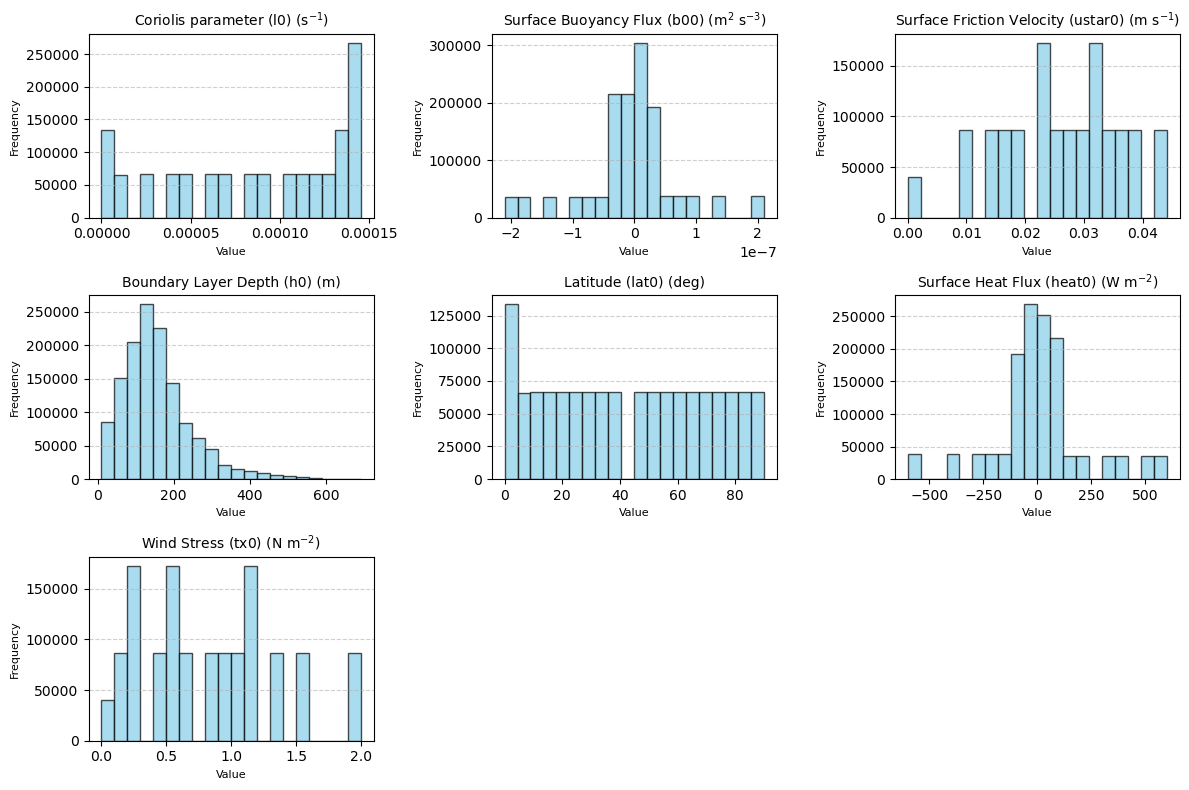

In [5]:
variables = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0.values.flatten(),
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00.values.flatten(),
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0.values.flatten(),
    "Boundary Layer Depth (h0) (m)": h0.values.flatten(),
    "Latitude (lat0) (deg)": lat0.values.flatten(),
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0.values.flatten(),
    "Wind Stress (tx0) (N m$^{-2}$)": tx0.values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(12, 8))
for i, (name, data) in enumerate(variables.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

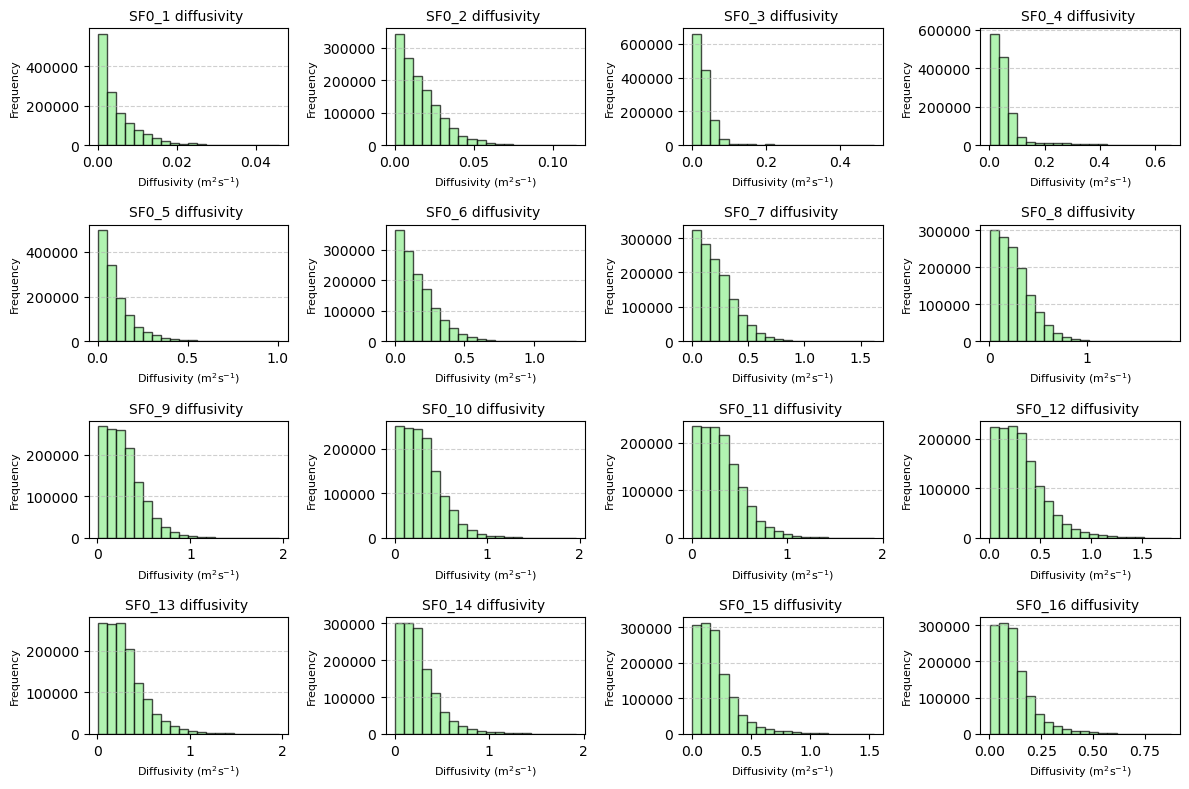

In [6]:
# Plot histograms of the distribution of vertical diffusivity (SF0) at each level from GOTM
#
# SF0_1 is adjacent to the BOTTOM of the OBSL - note small diffusivity values here (0-0.04)
# SF0_16 is TOP of the column - note greater diffusivity values here (0-0.75)
#
# Note that diffusivity ranges in each layer differ by 2 orders of magnitude

plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.hist(SF0[:, i].values.flatten(), bins=20, color="lightgreen", edgecolor="black", alpha=0.7)
    plt.title(f"SF0_{i + 1} diffusivity ", fontsize=10)
    plt.xlabel("Diffusivity (m$^2$s$^{-1}$)", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

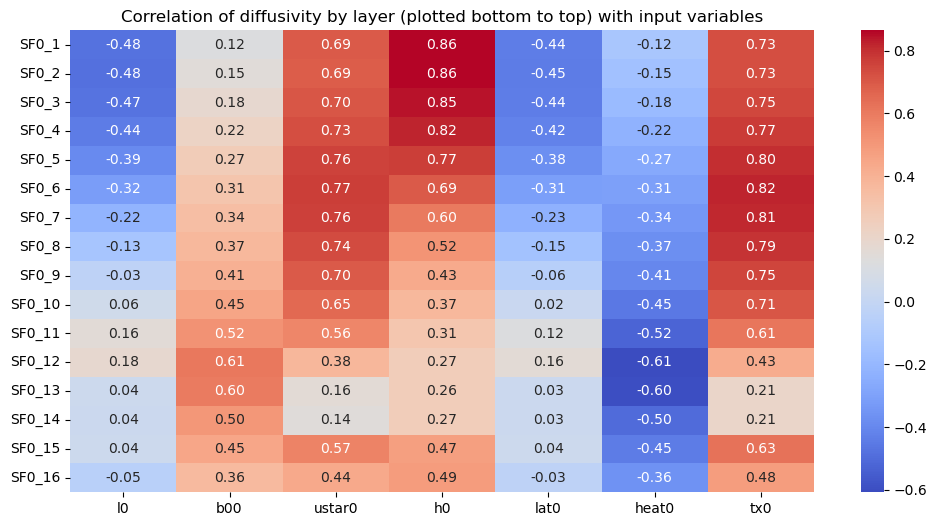

In [7]:
# How are the input data correlated to diffusivity at each level? Make a plot to consider this
data = {
    "l0": l0.values.flatten(),
    "b00": b00.values.flatten(),
    "ustar0": ustar0.values.flatten(),
    "h0": h0.values.flatten(),
    "lat0": lat0.values.flatten(),
    "heat0": heat0.values.flatten(),
    "tx0": tx0.values.flatten(),
}

for i in range(16):
    data[f"SF0_{i+1}"] = SF0[:, 16-i-1].values.flatten()

df = pd.DataFrame(data)

correlation_matrix = df.corr()

sf0_correlation = correlation_matrix.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0", "lat0", "heat0", "tx0"]]

plt.figure(figsize=(12, 6))
sns.heatmap(sf0_correlation, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of diffusivity by layer (plotted bottom to top) with input variables")
plt.show()


### Correlations with Input variables

Recall 
- SF0_1 is adjacent to BOTTOM of OBSL
- SF0_16 is adjacent to TOP of OBSL
- $\sigma = \frac{z}{h}$ is a normalized vertical coordinate, so the $\it{physical}$ depth of the OBSL is variable across the ocean (from a few meters in the lower latitudes and in summer at mid-latitudes, to 100s m in the mid-latitude winter, to >1000 m at high latitudes in winter)

The correlation between SF0 at each level and the input variables varies across depths. For example, buoyancy flux (b00) is more correlated with diffusivity higher in the column but measures of wind (ustar0, tx0) are more correlated with diffuivity nearer to the bottom of the OBSL. 

Keep in mind the variation in magnitudes of diffusivity from the plot above. 

## 2.3 Data Filtering
To ensure high-quality and valid data for training, specific filtering criteria are applied by Sane et al. (2023):

1. Heat flux ($ \text{heat} $) magnitude below 601 $ W/m^2 $.
2. Wind stress ($ \text{tx} $) below 1.2 $ N/m^2 $.
3. Boundary layer depth ($ \text{h} $) between 30 m and 300 m.

In [8]:
# Apply the constraints defined above
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

In [9]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)  
# Note: ff.preprocess_train_data is a custom function defined in lib/func_file.py that normalizes, log-transforms and shuffles the dataset


started


## 2.4 Validation Dataset

In this project, training and validation datasets are generated independently through separate simulations. This practice ensures **strict independence** between the two datasets, avoiding issues like **data leakage** or overfitting. 

In [10]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [11]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

# 3. Neural Network Architecture

The learnKappa_layers class is a neural network model built using PyTorch's nn.Module. It consists of three fully connected (linear) layers with ReLU activation and dropout for regularization. 

Define here a 2 hidden-layer model

In [12]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred


# 4. Model Training

The modeltrain_loss function trains a neural network model using PyTorch with a custom loss calculation and implements early stopping to prevent overfitting and save computing time.

Early Stopping: Stops training if the validation loss does not improve for patience consecutive epochs, saving the best model state. Increasing patience will further reduce loss, but lengthen runtime.

In [13]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            
            valid_pred = model(valid_x)  # Forward pass for validation data
            
            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred
            
    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k, :]


In [17]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [18]:
# Train N1 for the first time!
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:  26%|██▌       | 767/3000 [00:25<01:15, 29.56epoch/s, patience_count=19, train_loss=0.0387, valid_loss=0.0557]


Early stopping at epoch 767. Validation loss has not improved for 20 epochs.


# 5. Evaluation and Visualization

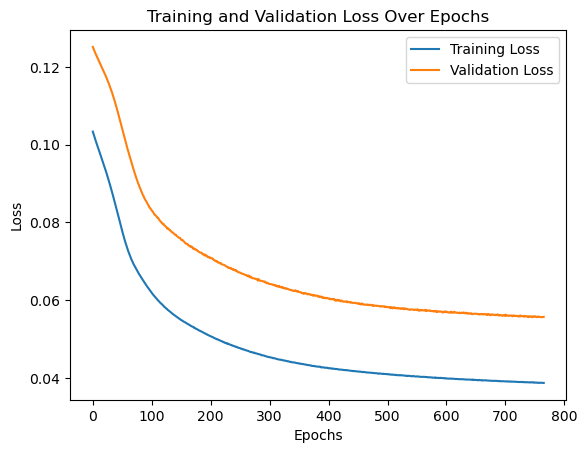

In [19]:
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


### Reproduce here Figure 4 of Sane et al (2023) using a function defined in /lib/visual_figure4.py
As in the training data from GOTM
- Node 1 is adjacent to BOTTOM of OBSL
- Node 16 is adjacent to TOP of OBSL 

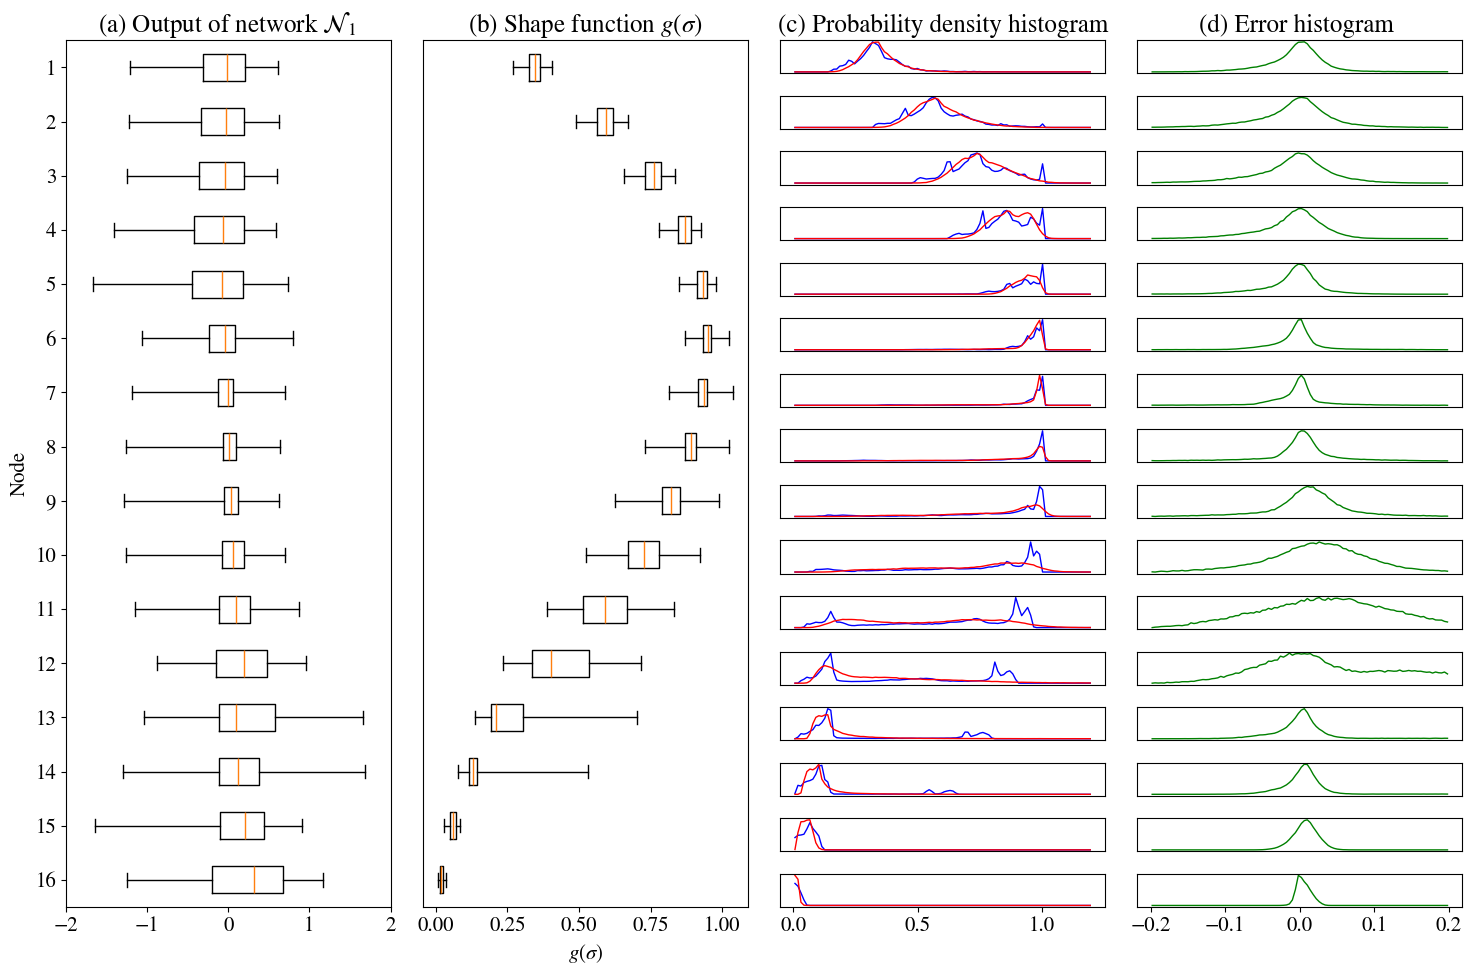

In [20]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

# 6. Further Exploration

## 6.1 Modifying Loss Function with Node-Specific Weighting

As discussed at the end of section 3.4 of Sane et al. (2023), we adjust the training process by modifying the loss function to prioritize nodes with higher variance. Key steps and configurations:

**Node-Specific Weighting**: We applied node-specific weights (`kmask`) to amplify the loss values for nodes 8 to 13 by a factor of 100 (`kms2 = 100.0`), while keeping the weight at other nodes as 1.0 (`kms1 = 1.0`). 

This approach helps focus the model on reducing errors for nodes with higher variance, making them easier to learn.

In [24]:
# Loss weighting option here 
# Weight settings here
kms1=1.0 
kms2=100.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms2; k12 = kms2; k11 = kms2; 
k10 = kms2; k9 = kms2; k8 = kms2; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [25]:
epochs, k_points, lr=3000, 16, 1e-03

# Loss weighting implemented here
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)


Training Progress:  38%|███▊      | 1132/3000 [00:38<01:03, 29.28epoch/s, patience_count=19, train_loss=0.0363, valid_loss=0.0535]


Early stopping at epoch 1132. Validation loss has not improved for 20 epochs.


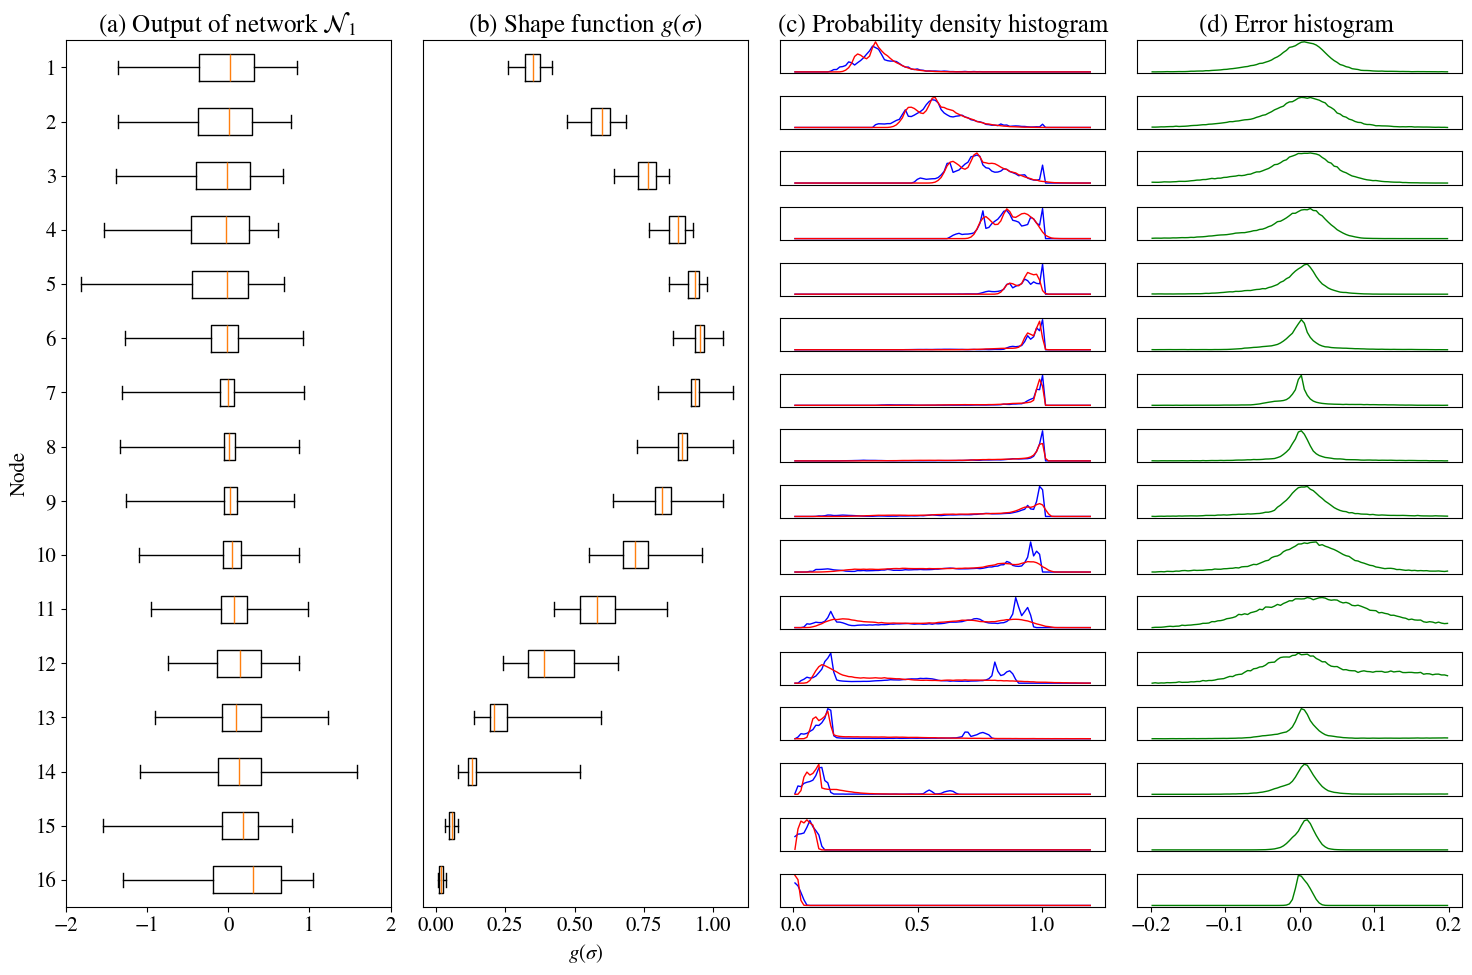

In [26]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

#### You will have to look closely to find differences from the unweighted training!

## 6.2 Hyperparameter Sweep for Network Architecture

In this section, we conducted a hyperparameter sweep to evaluate the performance of different neural network architectures by varying:
- The **number of layers**.
- The **number of hidden nodes per layer**.

#### Parameter Count Calculation
The number of trainable parameters for a given architecture is calculated as:
$$
P = \sum_{l=1}^{L} \big( n_{\text{input}, l} \times n_{\text{output}, l} + n_{\text{output}, l} \big)
$$
Where:
- $ n_{\text{input}, l} $: Number of input nodes to layer $l $.
- $ n_{\text{output}, l} $: Number of output nodes from layer $ l$.

Using a **4-core CPU with 32GB RAM**, the estimated computational time for training all models with the above configurations is many hours. 

- **We recommend using a GPU server.**  

- In addition, limit sweep to **1-2 layers** and **2-64 hidden nodes** per layer. This enables a much faster, but still meaningful evaluation of the model's depth and width.


In [27]:
# Loss weighting option here, all weights = 1.0 in hyperparameter sweep
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [28]:
## We perform hyper-parameter sweep in this section.

epochs, k_points, lr=3000, 16, 1e-03

hid_array=np.array([2,4,8,16,32,64])

lays = np.array([1,2])

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

first_print_done = False  # Ensure the success message prints only once

for la in lays:
    cwd_sd = cwd_output + 'ensemble_models_layers' + str(la) + '/'

    for h in hid_array:
        in_nod, hid_nod, o_nod = 4, h, 16
        print('la, h is >', la, h)

        if la == 1:
            model = ff.learnKappa_layers1(in_nod, hid_nod, o_nod)
        elif la == 2:
            model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)
        elif la == 3:
            model = ff.learnKappa_layers3(in_nod, hid_nod, o_nod)
        elif la == 4:
            model = ff.learnKappa_layers4(in_nod, hid_nod, o_nod)
        else:
            print('Check code')

        model = model.to(device)

        model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, 
                                            torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

        directory = os.path.join(cwd_sd, f'mod_dir_{h}')
        os.makedirs(directory, exist_ok=True)

        model_path = os.path.join(directory, 'model.pt')
        torch.save(model, model_path)

        loss_path = os.path.join(directory, 'loss_array.txt')
        np.savetxt(loss_path, loss_array.detach().numpy())

        if not first_print_done:
            if os.path.exists(model_path):
                print(f"Model saved successfully: {model_path}")
            else:
                print(f"Failed to save model: {model_path}")

            if os.path.exists(loss_path):
                print(f"Loss array saved successfully: {loss_path}")
            else:
                print(f"Failed to save loss array: {loss_path}")

            first_print_done = True  

        del model, loss_array
        torch.cuda.empty_cache()

torch.cuda.empty_cache()


la, h is > 1 2


Training Progress:  43%|████▎     | 1291/3000 [00:19<00:25, 66.41epoch/s, patience_count=19, train_loss=0.0666, valid_loss=0.0921]



Early stopping at epoch 1291. Validation loss has not improved for 20 epochs.
Model saved successfully: /home/jovyan/Teaching/CPCsp2025/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/model.pt
Loss array saved successfully: /home/jovyan/Teaching/CPCsp2025/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/loss_array.txt
la, h is > 1 4


Training Progress:  28%|██▊       | 844/3000 [00:13<00:33, 64.45epoch/s, patience_count=19, train_loss=0.066, valid_loss=0.0858] 



Early stopping at epoch 844. Validation loss has not improved for 20 epochs.
la, h is > 1 8


Training Progress:  25%|██▌       | 755/3000 [00:12<00:36, 61.63epoch/s, patience_count=19, train_loss=0.0582, valid_loss=0.0807]



Early stopping at epoch 755. Validation loss has not improved for 20 epochs.
la, h is > 1 16


Training Progress:  46%|████▌     | 1368/3000 [00:25<00:30, 54.05epoch/s, patience_count=19, train_loss=0.0482, valid_loss=0.0687]



Early stopping at epoch 1368. Validation loss has not improved for 20 epochs.
la, h is > 1 32


Training Progress:  35%|███▌      | 1061/3000 [00:24<00:45, 42.71epoch/s, patience_count=19, train_loss=0.0455, valid_loss=0.0667]



Early stopping at epoch 1061. Validation loss has not improved for 20 epochs.
la, h is > 1 64


Training Progress:  47%|████▋     | 1399/3000 [00:47<00:54, 29.53epoch/s, patience_count=19, train_loss=0.0396, valid_loss=0.0597]



Early stopping at epoch 1399. Validation loss has not improved for 20 epochs.
la, h is > 2 2


Training Progress:  32%|███▏      | 948/3000 [00:16<00:34, 58.70epoch/s, patience_count=19, train_loss=0.075, valid_loss=0.0937] 



Early stopping at epoch 948. Validation loss has not improved for 20 epochs.
la, h is > 2 4


Training Progress:  27%|██▋       | 799/3000 [00:14<00:39, 56.28epoch/s, patience_count=19, train_loss=0.0719, valid_loss=0.0882]



Early stopping at epoch 799. Validation loss has not improved for 20 epochs.
la, h is > 2 8


Training Progress:  32%|███▏      | 947/3000 [00:18<00:39, 52.03epoch/s, patience_count=19, train_loss=0.055, valid_loss=0.0739] 



Early stopping at epoch 947. Validation loss has not improved for 20 epochs.
la, h is > 2 16


Training Progress:  35%|███▍      | 1043/3000 [00:25<00:46, 41.66epoch/s, patience_count=19, train_loss=0.0453, valid_loss=0.0626]



Early stopping at epoch 1043. Validation loss has not improved for 20 epochs.
la, h is > 2 32


Training Progress:  36%|███▋      | 1091/3000 [00:37<01:05, 28.99epoch/s, patience_count=19, train_loss=0.0363, valid_loss=0.0522]



Early stopping at epoch 1091. Validation loss has not improved for 20 epochs.
la, h is > 2 64


Training Progress:  42%|████▏     | 1265/3000 [01:11<01:38, 17.64epoch/s, patience_count=19, train_loss=0.0286, valid_loss=0.0428]



Early stopping at epoch 1265. Validation loss has not improved for 20 epochs.


In [29]:
## Uncertainty in training 4-32-32-16 model: 
## this is 4 input + 2 layers with 32 hidden nodes in each layer + 16 output nodes  
ensemble_dir = cwd_output + 'ensemble_models_layers2_uncertainty'
os.makedirs(ensemble_dir, exist_ok=True)

epochs, k_points, lr = 3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

seeds = np.arange(10, 15)

for seed in seeds:
    print(f"Training with seed {seed}")
    # Define model directory for this seed
    model_dir = os.path.join(ensemble_dir, f'mod_dir_{seed}')
    
    os.makedirs(model_dir, exist_ok=True)

    model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)  # Update layers as needed
    model = model.to(device)

    # Train the model
    model, loss_array = modeltrain_loss(
        in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model,
        torch.tensor(kmask).float().to(device), k_mean_c, k_std_c
    )

    # Save model and loss array for this seed
    torch.save(model, os.path.join(model_dir, 'model.pt'))
    np.savetxt(os.path.join(model_dir, 'loss_array.txt'), loss_array.detach().numpy())


Training with seed 10


Training Progress:  43%|████▎     | 1296/3000 [00:44<00:58, 28.96epoch/s, patience_count=19, train_loss=0.0351, valid_loss=0.0503]



Early stopping at epoch 1296. Validation loss has not improved for 20 epochs.
Training with seed 11


Training Progress:  28%|██▊       | 845/3000 [00:29<01:14, 29.09epoch/s, patience_count=19, train_loss=0.0375, valid_loss=0.0536]



Early stopping at epoch 845. Validation loss has not improved for 20 epochs.
Training with seed 12


Training Progress:  34%|███▎      | 1005/3000 [00:34<01:08, 29.06epoch/s, patience_count=19, train_loss=0.0379, valid_loss=0.0546]



Early stopping at epoch 1005. Validation loss has not improved for 20 epochs.
Training with seed 13


Training Progress:  22%|██▏       | 669/3000 [00:23<01:21, 28.51epoch/s, patience_count=19, train_loss=0.0395, valid_loss=0.0558]



Early stopping at epoch 669. Validation loss has not improved for 20 epochs.
Training with seed 14


Training Progress:  41%|████      | 1233/3000 [00:42<01:00, 29.21epoch/s, patience_count=19, train_loss=0.0364, valid_loss=0.0519]


Early stopping at epoch 1233. Validation loss has not improved for 20 epochs.


Scores saved successfully.
Losses saved by seed successfully.


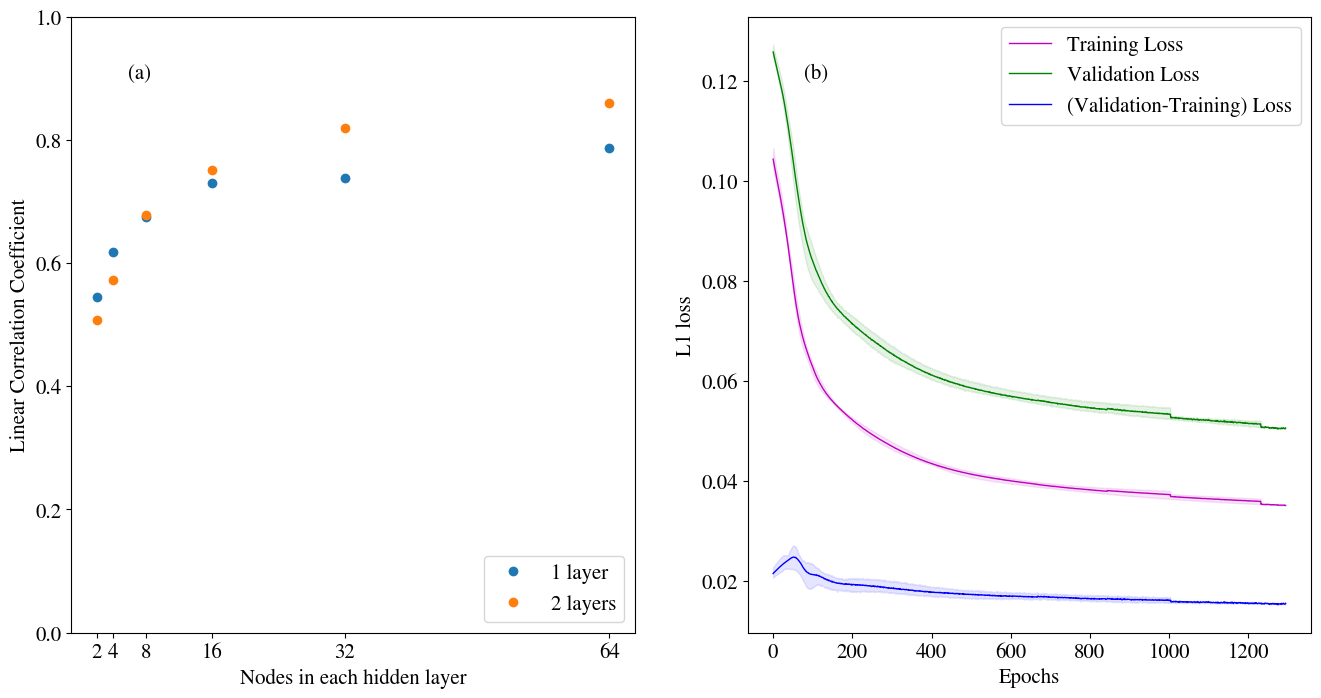

In [105]:
score_eval(hid_array, lays, valid_x, valid_y, k_mean_c, k_std_c, cwd_output)
save_losses_by_seed(os.path.join(cwd_output, 'ensemble_models_layers2_uncertainty/'), seeds)
plot_n1_scores(cwd_output, hid_array, lays, seeds, epochs=3000)

## Explanation and Discussion of Hyperparameter Sweep and Uncertainty Evaluation 
To identify the optimal hyperparameters for the model, we evaluate different configurations based on their **linear correlation coefficient** performance. The process is as follows:

- Hyperparameter Variation: We explore different numbers of hidden layers and nodes per layer. Each configuration is used to train the model, producing predictions for 16 $g(\sigma)$ points (denoted as $y$).

- Prediction Post-Processing: Each predicted $y$ is denormalized to restore its original scale. Extreme values (beyond the 5th-95th percentile) are removed to mitigate the influence of outliers, reduced the impact of noisy predictions. The Pearson correlation between the filtered predictions and the ground truth $y$ is computed.

- Final Correlation Computation: The mean correlation across all 16 $g(\sigma)$ points is taken as the final evaluation score for each hyperparameter set. This is plotted in (a). 

### Hyperparameter sweep, plot (a) 
Plot (a) shows that 2 layers with 64 nodes achieved the best performance under the linear correlation coefficient metric. 

**At 2 layers with 32 nodes, performance starts to asymptote. This is the structure selected in Sane et al. (2023) to balance skill and with computational cost.** 

Sane et al. (2023) Figure 3(a) shows a search up to 4 layers with 512 nodes. To reduce computational cost, we cut off the sweep at 2 layers with 64 nodes.

### L1 loss with uncertainty, plot (b)
Plot (b), for 2 layers with 32 nodes, we make an addition to Sane et al. (2023) by estimating uncertainty in model predictions by training with different random seeds. This captures variations in initialization. 

We use 5 random seeds to balance computational efficiency and result reliability. Increasing the number of seeds would provide a more robust estimation of uncertainty.